#Introduction

In [0]:
import os
from google.colab import files
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
#from pytorchtools import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [0]:
os.environ['KAGGLE_USERNAME'] = "" # username from the json file
os.environ['KAGGLE_KEY'] = "" # key from the json file

In [0]:
!pip install --upgrade kaggle
!pip install torch
!pip install torchvision
!pip install pytorchtools
!pip install albumentations
!pip install -U git+https://github.com/albu/albumentations

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-1e0kr1n7
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-1e0kr1n7
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65099 sha256=15f94a9804cd31852bb79950c42a2e67f815aa6cd3d2d71caf13d250876a9865
  Stored in directory: /tmp/pip-ephem-wheel-cache-wm11rd0s/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


In [0]:
uploaded = files.upload()

Saving msi-tinymnist2020.zip to msi-tinymnist2020.zip


In [0]:
!unzip -q msi-tinymnist2020.zip #uzipping dataset

In [0]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(2020)

#Loading Data

In [0]:
NUM_EPOCHS = 200 # number of times which the entire dataset is passed throughout the model
BATCH_SIZE = 64 # the size of input data took for one iteration
lr = 1e-3 # size of step

In [0]:
train_dataset = dsets.ImageFolder(
        root='TinyMNIST/train',
        transform=transforms.Compose([transforms.RandomRotation(30),
                                      transforms.Grayscale(num_output_channels=1),
                                      transforms.ToTensor()])
    )

train_set,valid_set =torch.utils.data.random_split(train_dataset, [3200, 800])

train_gen = torch.utils.data.DataLoader(dataset=train_set,
                                             batch_size = BATCH_SIZE,
                                             shuffle = True)

valid_gen = torch.utils.data.DataLoader(dataset = valid_set,
                                      batch_size = 800, 
                                      shuffle = False)


print('Loaded ', len(train_set), 'training images and ', len(valid_set), ' validation images.')
print('Classes detected: ', train_dataset.classes)

Loaded  3200 training images and  800  validation images.
Classes detected:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


#Architecture

In [0]:
class ConvNetwork(nn.Module):
  def __init__(self):
    super(ConvNetwork,self).__init__()
    # definition of layers
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3) # convolutional layer
    self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
    self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2, padding = 6)
    
    self.conv4 = nn.Conv2d(32, 64, kernel_size=3) # convolutional layer
    self.conv5 = nn.Conv2d(64, 64, kernel_size=3)
    self.conv6 = nn.Conv2d(64, 64, kernel_size=5, stride=2, padding = 2)

    self.conv7 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # convolutional layer
    self.conv8 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

    self.fc1 = nn.Linear(128*6*6, 256) # output layer
    self.fc2 = nn.Linear(256, 10)

    self.batch2d32 = nn.BatchNorm2d(32)
    self.batch2d64 = nn.BatchNorm2d(64)
    self.batch2d128 = nn.BatchNorm2d(128)

    self.batch1d = nn.BatchNorm1d(256)

    self.drop = nn.Dropout(0.35)
    self.drop2d = nn.Dropout2d(0.35)
    
    self.relu = nn.ReLU() # activation function: relu

  # definition how the signal goes through the network
  def forward(self,x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.batch2d32(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.batch2d32(x)
    x = self.conv3(x)
    x = self.relu(x) 
    x = self.batch2d32(x)
    x = self.drop2d(x)

    x = self.conv4(x)
    x = self.relu(x)
    x = self.batch2d64(x)
    x = self.conv5(x)
    x = self.relu(x)  
    x = self.batch2d64(x)
    x = self.conv6(x)
    x = self.relu(x)  
    x = self.batch2d64(x)
    x = self.drop2d(x)

    x = self.conv7(x)
    x = self.relu(x)
    x = self.batch2d128(x)
    x = self.conv8(x)
    x = self.relu(x)  
    x = self.batch2d128(x)
    x = self.drop2d(x)

    x = x.view(-1, 128*6*6)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.batch1d(x)
    x = self.drop(x)

    out = self.fc2(x)
    return out

In [0]:
net = ConvNetwork()

#Loss Function

In [0]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr = lr/10, max_lr = lr, mode='triangular', cycle_momentum=False)

#Training

In [0]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [0]:
print('Start training')
early_stopping = EarlyStopping(patience=20, verbose=True)

train_losses = []
valid_losses = []
avg_train_losses = []
avg_valid_losses = []

for epoch in range(NUM_EPOCHS):
  
  net.train()
  for i,(images,labels) in enumerate(train_gen):

    optimizer.zero_grad()
    outputs = net(images)

    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
  
  scheduler.step()

  net.eval()
  for images, labels in valid_gen:
    outputs = net(images)
    loss = loss_function(outputs, labels)
    valid_losses.append(loss.item())

  train_loss = np.average(train_losses)
  valid_loss = np.average(valid_losses)
  avg_train_losses.append(train_loss)
  avg_valid_losses.append(valid_loss)

  train_losses = []
  valid_losses = []
  
  if early_stopping.early_stop:
    print("Early stopping")
    break


  print('\repoch: ',epoch,"/ ",NUM_EPOCHS, loss,end="")

Start training
epoch:  199 /  200 tensor(0.1472, grad_fn=<NllLossBackward>)

#Testing

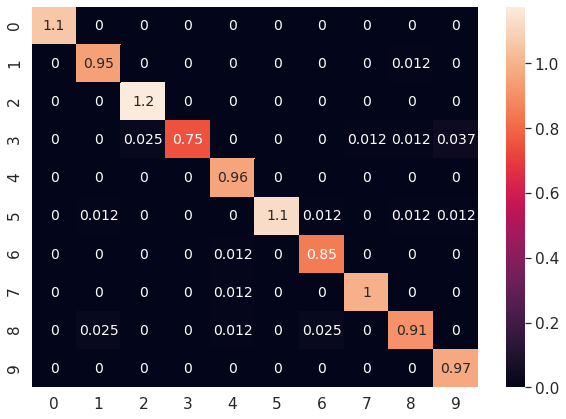

In [0]:
def plot_confusion_matrix(valid_gen):
  confusion_matrix = torch.zeros(10, 10)
  with torch.no_grad():
      for i, (images,labels) in enumerate(valid_gen):
          outputs = net(images)
          _, preds = torch.max(outputs, 1)
         
          for t, p in zip(labels.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1

  df_cm = pd.DataFrame(confusion_matrix.cpu().detach().numpy()/len(valid_gen.dataset)*10, range(10), range(10))
  plt.figure(figsize=(10,7))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}) # font size
  plt.show()

plot_confusion_matrix(valid_gen)

#Outputs Generations

In [0]:
def predict(test_gen):
  with torch.no_grad():
  
      for data, labels in test_gen:
        print(data.size())
        outputs = net(data)
        _, preds = torch.max(outputs, 1)
  return preds

test_dataset = dsets.ImageFolder(
        root='TinyMNIST/test',
        transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor()]),
    )

test_gen = torch.utils.data.DataLoader(dataset=test_dataset,
                                             batch_size = 600,
                                             shuffle = False)
preds = predict(test_gen)

torch.Size([600, 1, 28, 28])


#Submission File Generation

In [0]:
def generate_submission(predictions,test_dataset):
  ids = []
  labels = []
  for predictions,sample in zip(predictions,test_dataset.imgs):
    ids.append(predictions)
    sample=list(sample)[0]
    labels.append(int(sample.split("_",1)[1].split(".",1)[0]))
  ids_s,labels_s = zip(*sorted(zip(labels, ids)))
  df = pd.DataFrame()
  df['id']=ids_s
  df['category']=labels_s
  df.set_index('id',inplace = True)
  print(df.head())
  df.to_csv('test_submission.csv', header=True)

generate_submission(preds,test_dataset)

    category
id          
0          1
1          0
2          1
3          4
4          0


#Send file

In [0]:
!kaggle competitions submit -c msi-tinymnist2020 -f test_submission.csv -m "Jupyter notebook test submission"

100% 3.42k/3.42k [00:03<00:00, 1.14kB/s]
Successfully submitted to MSI Tiny MNIST Challenge 2020